# <center> Mini Project 1 - Classification of Wind Turbine Alarms </center>

## <center> MSDS 7331 Data Mining - Section 401 - Mini Project 1 </center> 
### <center> Team:  Sarah Fite, Sheri Loftin, Casey Martinez, Kyle Thomas </center>




<a id="top"></a>
# Table of Contents
* <a href="#Imports and Data">Imports and Data</a>
    - Cleaning the Data
    - Merging the Data
    - Create New Variables
    - Reducing Dataset
* <a href="#Create Models">**Create Models</a>
     - Support Vector Machine (SVM) Model 
       - Visualizations
       - Classification of Turbine Performance
       - Support Vector Machine Preprocessing
       - Training and Test Data Creation (80/20 Split)
       - Model creation and Parameter Optimization With Grid Search
       - Results
       - **Interpret Support Vectors
     - Logistics Regression 
       - **Feature Importance 
       -  Reference Section
       -  Visualizations
* <a href="#Model Advantages">**Model Advantages</a>

"**" Denotes items from syllabus

# Imports and Data

For this project, we continue to examine data provided by Siemens, the wind turbine manufacturer, and Pattern Energy, the owner/operator (Casey Martinez's employer).  For this project we analyze this dataset using both Logistics Regression and Support Vector Machines (SVM).

The background of this data and the business understanding behind it can be found as part of Project 1 at: https://github.com/CaseyRMartinez/DataMiningProject1/blob/master/DataMiningProject1_V5.ipynb

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import sklearn
import seaborn as sns
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline
import pylab
from scipy.optimize import curve_fit
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import matplotlib as mpl
pd.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.6.1.final.0
python-bits: 64
OS: Windows
OS-release: 10
machine: AMD64
processor: Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
byteorder: little
LC_ALL: None
LANG: None
LOCALE: None.None

pandas: 0.23.0
pytest: 3.0.7
pip: 10.0.1
setuptools: 27.2.0
Cython: 0.25.2
numpy: 1.12.1
scipy: 0.19.0
pyarrow: None
xarray: None
IPython: 5.3.0
sphinx: 1.5.6
patsy: 0.4.1
dateutil: 2.6.0
pytz: 2017.2
blosc: None
bottleneck: 1.2.1
tables: 3.2.2
numexpr: 2.6.2
feather: None
matplotlib: 2.0.2
openpyxl: 2.4.7
xlrd: 1.0.0
xlwt: 1.2.0
xlsxwriter: 0.9.6
lxml: 3.7.3
bs4: 4.6.0
html5lib: 0.9999999
sqlalchemy: 1.1.9
pymysql: 0.8.0
psycopg2: None
jinja2: 2.9.6
s3fs: None
fastparquet: None
pandas_gbq: None
pandas_datareader: None


To start, we will first look at the alarm data and one quarter worth of wind farm supervisory control and data acquisition (SCADA) system data.  This SCADA data is specifically used for performance monitoring of large utility-scale wind turbines.

In [5]:
#path = '~/Documents/thomaskh522@gmail.com/SMU/DataMining/MiniProject/Data/'
path = 'D:/Pattern/'
alarms_desc = pd.read_csv(path + "Siemens_Fault_Code_Descriptions.csv")
scada = pd.read_csv(path + "SCADAcombined2017Q1.csv")
print('alarm description shape:',alarms_desc.shape)
print('scada data shape:',scada.shape)

alarm description shape: (2141, 3)
scada data shape: (1111023, 79)


### Cleaning the Data

Next, we dropped missing values from our dataset and removed irrelevant columns.  

In [6]:
# drop columns that were missing values
scada.dropna(thresh=10000,axis=1,inplace=True)

colsdrop = ['StationId', 'CommunicationId', 'NeighbourId',
           'NeighbourIdTwo', 'XPos', 'YPos', 'wtc_ActPower_min',
           'wtc_ActPower_max', 'wtc_ActPower_stddev',
           'wtc_AmpPhR_min', 'wtc_AmpPhR_max', 'wtc_AmpPhR_mean',
           'wtc_AmpPhR_stddev', 'wtc_AmpPhS_min', 'wtc_AmpPhS_max',
           'wtc_AmpPhS_mean', 'wtc_AmpPhS_stddev', 'wtc_AmpPhT_min',
           'wtc_AmpPhT_max', 'wtc_AmpPhT_mean', 'wtc_AmpPhT_stddev',
           'wtc_RawPower_min', 'wtc_RawPower_max', 'wtc_RawPower_mean',
           'wtc_RawPower_stddev', 'wtc_GenRpm_mean',
           'wtc_MainSRpm_mean', 'wtc_PitchRef_BladeA_mean',
           'wtc_PitchRef_BladeB_mean', 'wtc_PitchRef_BladeC_mean','wtc_TwrHumid_mean', 
            'wtc_PitcPosA_mean','wtc_PitcPosB_mean', 'wtc_PitcPosC_mean','wtc_BoostKWh_endvalue',
           'wtc_GeOilTmp_mean','wtc_HubTemp_mean','wtc_NacelTmp_mean','wtc_ConvWTmp_mean',
           'wtc_MainBTmp_mean','WindDir_Angle_3D_Avg','WindDir_Angle_3D_Std','WindDir_Angle_3D_Avg',
           'WindDir_Angle_3D_Std']

scada.drop(colsdrop,axis=1,inplace=True)

#turbines = ['T003','T062','T093']
turbines = ['T014']
#turbines = ['T003','T009','T014','T015','T022','T056','T071'] # known main bearing failures

scada = scada.loc[(scada['Name'].isin(turbines))]

print('scada data shape:',scada.shape)

#scada.isnull().sum()

scada data shape: (12817, 30)


### Merging the Data

After cleaning the data, we merged the alarm data with the SCADA Q1 data in order to conduct logistics regression and SVM prediciton. The following shows the shape of the data after merge.

In [7]:
# merge the alarms with the alarm descriptions

scada.dropna(inplace=True)
scada['wtc_AlarmCde_endvalue'] = scada['wtc_AlarmCde_endvalue'].astype(int)

df = scada.merge(alarms_desc, 
         left_on = 'wtc_AlarmCde_endvalue', 
         right_on="Code",
         how='left')

# del alarms_desc

df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
df.set_index('TimeStamp', inplace=True)
df.index

df.dropna(inplace=True)

print(df.shape)
df.describe().transpose()

(12817, 32)


,count,mean,std,min,25%,50%,75%,max
wtc_ActPower_mean,12817.0,1189.332189,773.781787,-37.015380,480.52380,1157.535000,1922.141000,2423.161000
wtc_YawPos_mean,12817.0,183.801289,94.347807,0.004588,143.80010,187.585000,236.374800,359.997200
wtc_BoostAva_mean,12817.0,4.048210,20.462076,0.000000,0.00000,0.000000,0.000000,115.000000
wtc_PowerRef_endvalue,12817.0,1829.020208,610.967977,0.000000,1408.00000,2229.000000,2300.000000,2300.000000
wtc_AcWindSp_mean,12817.0,8.636245,3.322997,0.000000,6.25969,8.575985,11.080750,21.409410
wtc_AcWindSp_stddev,12817.0,1.097100,0.454415,0.000000,0.77071,1.041948,1.345945,4.129087
wtc_NacelPos_mean,12817.0,183.801293,94.347805,0.004054,143.80010,187.584900,236.374800,359.997100
wtc_AmbieTmp_mean,12817.0,13.751620,6.995354,-7.980150,9.00000,14.756920,19.000000,30.000000
wtc_HydOilTm_mean,12817.0,30.908180,1.659110,25.458650,30.07040,30.356170,30.946700,41.000000
wtc_AlarmCde_endvalue,12817.0,37.686900,1314.321404,0.000000,0.00000,0.000000,0.000000,64066.000000


### Create New Variables

We know through independent research and analysis that certain calculated values would strengthen our model, but are not present in our current dataset. Thus, we chose to calculate, create, and add these values to our merged data set.  The variables are:
- WindSpeed_adj - variable created for grouping purposes
- Fault_Type- renamed existing "Fault Type" column to "Fault_Type" and recodes it as integer
- Derated - derating is oeprating a device at less than its optimal capacity in order to prolong its life.  Derating is commonly used on windfarms to prolong the life of a turbine.
- Available- reflects whether or not a turbine is available based faults and if its powered on.
- Air Density- calculates and stores air density calculations
- Hour of Day- adjusted wind speed to reflect nighttime changes
- Boosted Ref- adding a boost for to reference set point
- Wind Sheer- variation in wind velocity occurring in direction at right angles to wind's direction and tending to exert a turning force.
- Boosted Power Delta- The boosted ref minus the mean
- Icing- mathematical calculation to account for ice on turbine
- Air Density Adjusted Wind Speed- mathematical calculation to account for air density and windspeed on turbine performance
- Turbulence- mathematical calculation to account for turbulence on turbine performance
- Main Bearing Fault- recoding for fault code on Main Bearing
- Expected Energy- Calculation to reflect the Power Curve impact on the Wind Speed mean
- Expected Energy25th- Calculation to reflect the 25th percentile Power Curve impact on the Wind Speed mean
- Expected Energy Median-Calculation to reflect the median percentile Power Curve impact on the Wind Speed mean 
- Underperformance- variable created to store whether turbine is underperforming

In [10]:
# Create new variables

# Rounded Wind Speed for GroupBy
df['WindSpeed_adj'] = df['wtc_AcWindSp_mean'].round(1)

# Wind changes at night
df['HourOfDay'] = df.index.hour

# Yaw Error
df['YawError'] = df['wtc_YawPos_mean'] - df['WindDir_ICEFREE_D1_WVT']

# Adding boost to ref set point
df['BoostedRef'] = df['wtc_BoostAva_mean'] + df['wtc_PowerRef_endvalue']

# Wind Sheer
df['WindSheer1'] = np.log(df['WS_Thies_80m_Avg'] / df['WS_Thies_26m_Avg']) / np.log(80/26)
# df['WindSheer2'] = np.log(df['WS_Thies_80m_Avg'] / df['WS_Thies_60m_Avg']) / np.log(80/60)

# Fault Types
df = df.rename(columns={'Fault Type': 'Fault_Type'})
df['Fault_Type'] = df['Fault_Type'].replace('W','0')
df['Fault_Type'] = df['Fault_Type'].astype(int)

# Boosted Power Delta
df['PowerDelta'] = df['BoostedRef'] - df['wtc_ActPower_mean']

available = (df['Fault_Type'] != 1) & (df['wtc_ScInOper_timeon'] == 600)
df['Available'] = [1 if x == True else 0 for x in available]

# Icing
icing = (df['AirTC_3m_Avg'] < 3) & (abs(df['WS_ICEFREE_Avg'] - df['WS_Thies_80m_Avg']) > 1)
df['Icing'] = [1 if x == True else 0 for x in icing]

# Air Density
df['Air_density'] = (df['BP_mbar_76m_Avg']*100)/((df['AirTC_3m_Avg']+273.15)*287.05)

# Air Density adjusted Wind Speed
df['AdjTurbineWS'] = df['wtc_AcWindSp_mean']*(np.power(df['Air_density'],(1/3)))

# Turbulence
df['TurbulenceMet'] = df['WS_Thies_80m_Std'] / df['WS_Thies_80m_Avg']
df['TurbulenceTurbine'] = df['wtc_AcWindSp_stddev'] / df['wtc_AcWindSp_mean']

# df['MainBearingFault'] = [1 if x == 64038 else 0 for x in df['Code']]

df.dropna(inplace=True)

#### Turbine Derate Conditions

It is difficult to which conditions the reference set point actually limits the performance of the turbine. We need to categorize these conditions to remove them from our data set when fitting a curve to good performance data.

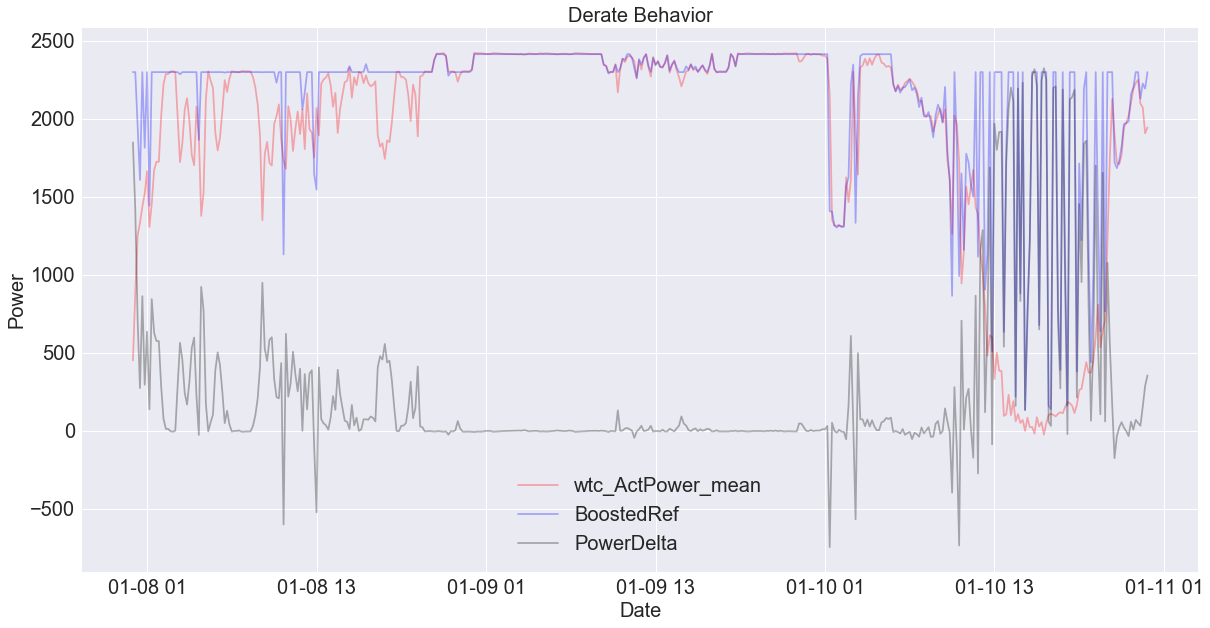

In [9]:
# Visualize the reference set point

df_derate = df['1-8-2017':'1-10-2017']

x1 = df_derate.index.values
y1 = df_derate['wtc_ActPower_mean'] 

x2 = df_derate.index.values
y2 = df_derate['BoostedRef'] 

x3 = df_derate.index.values
y3 = df_derate['PowerDelta'] 

plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

plt.plot(x1, y1,alpha=0.3, label='wtc_ActPower_mean', c='r')
plt.plot(x2, y2,alpha=0.3, label='BoostedRef', c='b')
plt.plot(x3, y3,alpha=0.3, label='PowerDelta', c='k')
# plt.axhline(y=2300, color='k')
plt.title("Derate Behavior")
plt.xlabel('Date')
plt.ylabel('Power')
plt.legend(loc='best')
plt.show()

In [11]:
# Calculating Derate Conditions

#derate = (df['wtc_ActPower_mean'] == df['wtc_PowerRef_endvalue']) & (df['wtc_PowerRef_endvalue'] < 2300)
#derate = (df['wtc_PowerRef_endvalue'] < 2300)
derate = (df['PowerDelta'] < 0) & (df['Available'] == 1) & (df['BoostedRef'] < 2300) #df['BoostedRef'].max())
df['Derated'] = [1 if x == True else 0 for x in derate]

percent = (df['Derated'].sum() / len(df))*100
print('Percent of Derated Data:',percent,"%")

Percent of Derated Data: 9.31647940075 %


#### Cleaned Power Curve

In [13]:
# Use cleaned data set for calculating expected energy
clean = (df['Available'] == 1) & (df['wtc_PowerRef_endvalue'] == 2300) & (df['Icing'] == 0) & (df['wtc_BoostAva_mean'] == 0)
df_clean = df[clean]

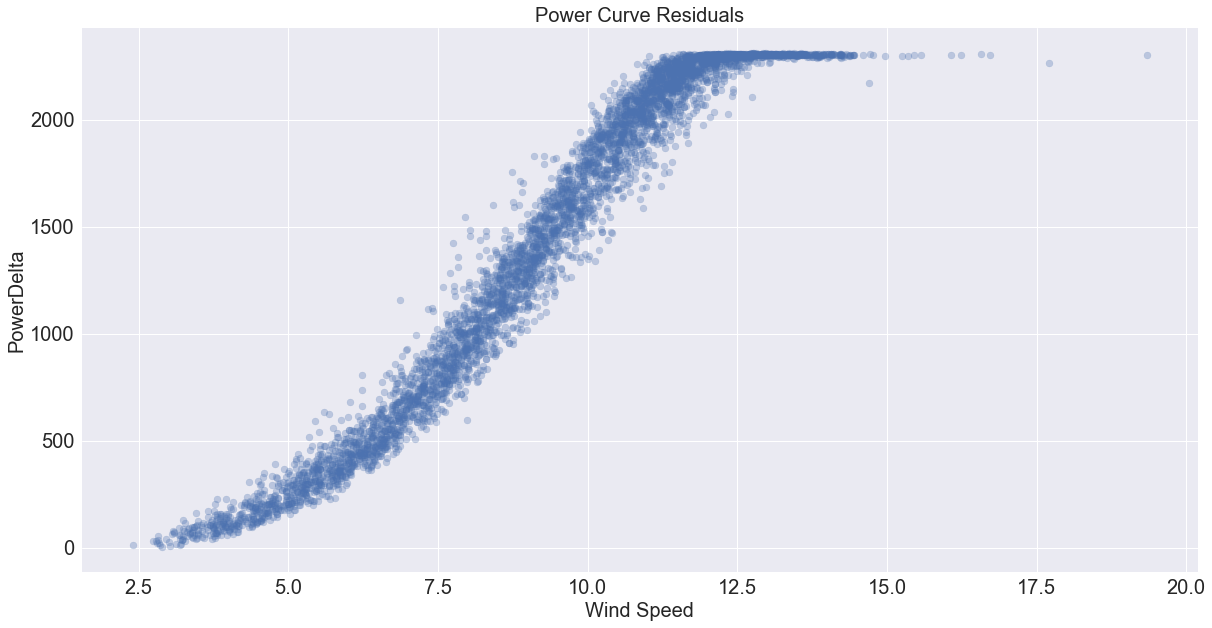

In [14]:
# x1 = df2['wtc_AcWindSp_mean']
# y1 = df2['Residual_median'] 

x2 = df_clean['wtc_AcWindSp_mean']
y2 = df_clean['wtc_ActPower_mean'] 
# c = df_clean['Icing']

# x3 = df2['wtc_AcWindSp_mean']
# y3 = df2['Residual_ref']

plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

# plt.scatter(x1, y1,alpha=0.3, label='Median', c='r')
plt.scatter(x2, y2,alpha=0.3)#, c=c)
# plt.scatter(x3, y3,alpha=0.3, label='Reference', c='k')
# plt.axhline(y=2300, color='k')
plt.title("Power Curve Residuals")
plt.xlabel('Wind Speed')
plt.ylabel('PowerDelta')
# plt.legend()
plt.show()

<a id="Models"></a>
<a href="#top">Back to Top</a>
# Models

<b>[50 points]</b>

<i>
Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). <b>Adjust parameters of the models to make them more accurate</b>. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 
</i>


## Support Vector Machine (SVM) Model

# Data Visualizations

Following the management of our dataset, we set out to capture various visualizations of our data.

### Plotting Historical Quantiles

In [15]:
pcurve95 = df_clean.groupby('WindSpeed_adj').quantile(q=0.95)
pcurve75 = df_clean.groupby('WindSpeed_adj').quantile(q=0.75)
pcurve50 = df_clean.groupby('WindSpeed_adj').median()
pcurve25 = df_clean.groupby('WindSpeed_adj').quantile(q=0.25)
pcurve5 = df_clean.groupby('WindSpeed_adj').quantile(q=0.05)

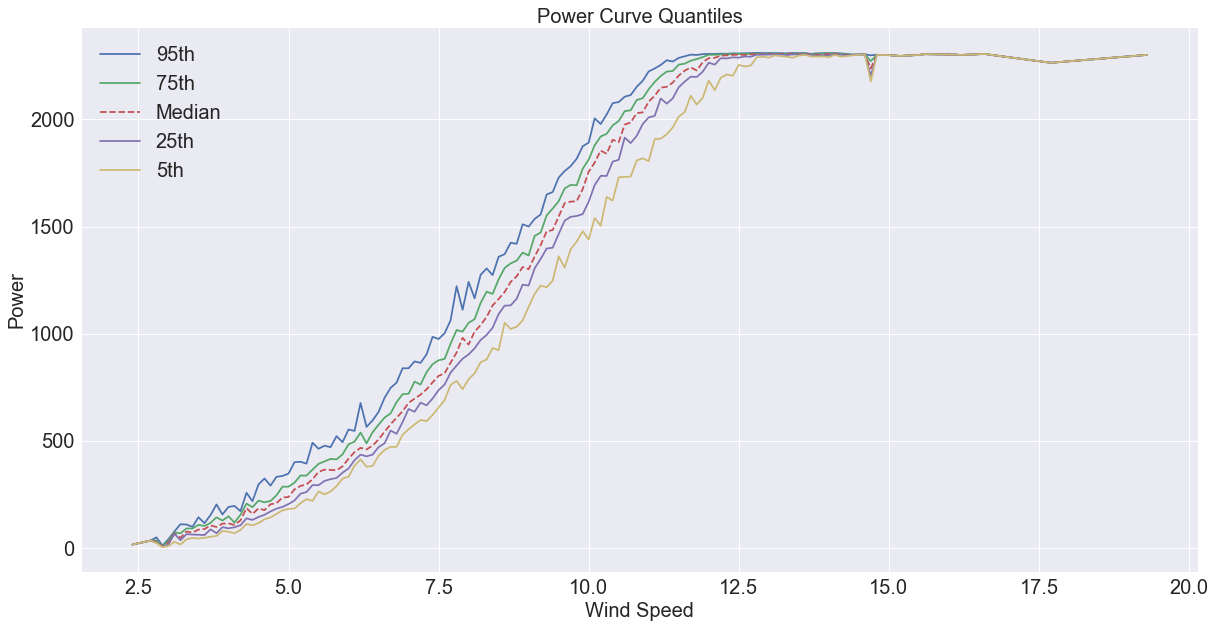

In [16]:
x1 = pcurve95.index.values
y1 = pcurve95['wtc_ActPower_mean'] 

x2 = pcurve75.index.values
y2 = pcurve75['wtc_ActPower_mean'] 

x3 = pcurve50.index.values
y3 = pcurve50['wtc_ActPower_mean'] 

x4 = pcurve25.index.values
y4 = pcurve25['wtc_ActPower_mean'] 

x5 = pcurve5.index.values
y5 = pcurve5['wtc_ActPower_mean'] 

plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

plt.plot(x1, y1, label='95th')
plt.plot(x2, y2, label='75th')
plt.plot(x3, y3, linestyle = 'dashed', label='Median')
plt.plot(x4, y4, label='25th')
plt.plot(x5, y5, label='5th')

# plt.axhline(y=2300, color='k')
plt.title("Power Curve Quantiles")
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.legend()
plt.show()

### Sigmoid Curve Fitting

x0: 8.91205828646
k: 0.684020529235
Cap: 2305.177


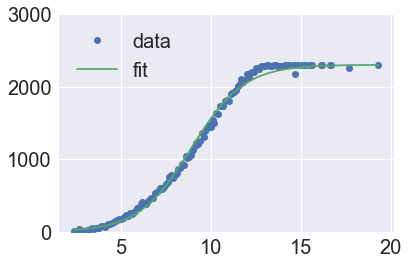

In [17]:
# Historical 5th Percentile

import pylab
from scipy.optimize import curve_fit
#from sklearn import preprocessing

def sigmoid(x, x0, k):
    #cap = 2300
    y = cap / (1 + np.exp(-k*(x-x0)))
    return y

xdata = pcurve5.index.values
ydata = pcurve5['wtc_ActPower_mean'].values
cap = np.max(pcurve5['wtc_ActPower_mean'].values)

popt, pcov = curve_fit(sigmoid, xdata, ydata)

pcurve5_x0 = popt[0]
pcurve5_k = popt[1]
pcurve5_cap = cap
print('x0:',pcurve5_x0)
print('k:',pcurve5_k)
print('Cap:',pcurve5_cap)

x = xdata
y = sigmoid(x,*popt)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(xdata,y, label='fit')
pylab.ylim(0, 3000)
pylab.legend(loc='best')
pylab.show()

### Apply Curve Fitting Paramters to DataFrame

In [18]:
def PowerCurve(wind, x0,k,cap):
    y = cap / (1 + np.exp(-k*(wind-x0)))
    return y

df['ExpectedEnergy_ref'] = df.apply(lambda x: PowerCurve(wind=x['wtc_AcWindSp_mean'], 
                                                          x0=7.70514731, 
                                                          k=0.85471648, 
                                                          cap=2300), 
                                     axis = 1)
df['ExpectedEnergy_5th'] = df.apply(lambda x: PowerCurve(wind=x['wtc_AcWindSp_mean'], 
                                                          x0=pcurve5_x0, 
                                                          k=pcurve5_k,
                                                          cap=pcurve5_cap), 
                                     axis = 1)


### Turbine Performance Classification
The goal of our SVM model is to predict if a wind turbine is performing in one of three ways: 

- minimum performance 
- average (or median performance) 
- maximum performance

We will achieve this analysis, first, through feature engineering.

#### Feature Engineering

We achieve feature engineering through class label creation. This is done by creating a simple function and applying it to the data frame.

In [19]:
# Make labels
# insipred by: https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns

def make_class(row):
    if row["wtc_ActPower_mean"] <= row["ExpectedEnergy_5th"]:
        return "1"
    else:
        return "0"

df["Underperformance"] = df.apply(lambda x: make_class(x), axis=1)
df['Underperformance'] = df['Underperformance'].astype(int)

percent = (df['Underperformance'].sum() / len(df))*100
print('Percent of Under Performance Data:',percent,"%")

Percent of Under Performance Data: 18.2194132335 %


### Support Vector Machine Preprocessing

According to several references,  the SVM classifer benefits greatly from data scaling. Specifically, it can speed up the training process significantly. SciKitLearn has some built in functions to expedite this processs. First, however, before this process can begin, the variables must be encoded from the string class variable into a numeric variable that can be interpreted by SciKitLearn.

In [21]:
#Encode the labels (examples found on SKLearn website... need to find address)
le = preprocessing.LabelEncoder()
le.fit(list(df["Underperformance"].unique()))
# df_test["target"] = le.transform(df_test["Underperformance"])
df["target"] = le.transform(df["Underperformance"])


#Now the other variables used to train the model need to scaled. First, however, un-need variables need to be dropped.
y = df["target"]
# y2= df['target']



# df3 = df.drop(['wtc_GeOilTmp_mean',
#        'wtc_HubTemp_mean', 'wtc_NacelTmp_mean', 'wtc_ConvWTmp_mean',
#        'wtc_HydOilTm_mean', 'wtc_MainBTmp_mean', 'wtc_AlarmCde_endvalue',
#        'wtc_ScInOper_timeon', 'WindSpeed_adj','ExpectedEnergy_ref', 'ExpectedEnergy_25th',
#        'ExpectedEnergy_median', 'Underperformance','wtc_ActPower_mean','Fault_Type','Code', 
#         'Description', 'Fault_Type','Name','Derated','target'], axis=1)

# keepcols2 = ["Air_density", "wtc_ScInOper_timeon", "AirTC_3m_Avg", "WS_Thies_60m_Avg", 
#              "WS_ICEFREE_Avg", "BP_mbar_76m_Avg"]

keepcols = ['BoostedRef', 'WindSheer1',
            'wtc_AcWindSp_mean','wtc_NacelPos_mean','wtc_ScInOper_timeon', 
            'WS_Thies_80m_Avg', 'WS_Thies_60m_Avg', 'WS_ICEFREE_Avg',
           'BP_mbar_76m_Avg', 'AirTC_3m_Avg','Icing','Air_density']

data = df[keepcols]

X = preprocessing.scale(data) 
# X2 = preprocessing.scale(df3)

data.columns

Index(['BoostedRef', 'WindSheer1', 'wtc_AcWindSp_mean', 'wtc_NacelPos_mean',
       'wtc_ScInOper_timeon', 'WS_Thies_80m_Avg', 'WS_Thies_60m_Avg',
       'WS_ICEFREE_Avg', 'BP_mbar_76m_Avg', 'AirTC_3m_Avg', 'Icing',
       'Air_density'],
      dtype='object')

### Training and Test Data Creation (80/20 Split)

In [22]:
#  Make test and training data
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)

In [23]:
X_train

array([[ 0.76006153, -0.75420089,  0.5482042 , ..., -0.82954514,
        -0.0751646 ,  0.64158224],
       [ 0.76006153, -0.49577725,  0.11937576, ..., -1.80241893,
        -0.0751646 ,  1.75719186],
       [-1.46493906,  0.85977642, -0.49317506, ..., -1.54892094,
        -0.0751646 ,  1.54997811],
       ..., 
       [ 0.76006153,  0.10259051,  0.0503551 , ..., -0.71656624,
        -0.0751646 ,  0.67601082],
       [-1.22241888, -0.66903799, -0.59985269, ..., -0.79086075,
        -0.0751646 ,  0.47001664],
       [ 0.76006153, -0.75680487, -0.40348959, ..., -1.4178808 ,
        -0.0751646 ,  1.59985915]])

### Model Creation and Parameter Optimization With Grid Search

Running the SVC classifier within SciKit Learn proved to be to costly computationally. As a result, we proceeded with a differnt SVM Classifier. Specifically, we use the SGDClassifier which utilized stochastic gradient descent and greatly increased training rates.

Since there are many possible parameters that can be put into the classifer, I ran through various alphas (or a penalty penalty term), learning rates, and learning rate schedules to find the strongest possible model based on the input parameters. This was done using a grid search.

http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

## Results
The best SGDClassifer had the following attributes: 'alpha': 1e-06, 'eta0': 0.5, 'learning_rate': 'invscaling'

The resulting model had an accuracy of 72.45 percent. 

In [25]:
# Thanks to sklearn for a great example: 
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
from sklearn import linear_model

# Set the parameters by cross-validation
clist = [0.1, 1, 10, 100]
tuned_parameters = [#{'kernel': ['rbf'], 'C': clist},
                    {'kernel': ['linear'], 'C': clist}
#                     {'kernel': ['poly'], 'C': clist},
#                     {'kernel': ['sigmoid'], 'C': clist}
                   ]

alphas = 10.0**-np.arange(1,7)
tp = [{'alpha':alphas, 'learning_rate':['constant', 'optimal', 'invscaling'], 'eta0': [0.01, 0.1, 0.5, 1.0]}]

# clf = GridSearchCV(svm.SVC(), tuned_parameters)
clf = GridSearchCV(linear_model.SGDClassifier(), tp)
# clf = svm.SVC(kernel='linear', C=1
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
# print("The model is trained on the full development set.")
# print("The scores are computed on the full evaluation set.")
# print()
y_true, y_pred = y_test, clf.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print(classification_report(y_true, y_pred))
print()
print("Accuracy:", acc)

C:\Users\Casiano\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Best parameters set found on development set:

{'alpha': 9.9999999999999995e-07, 'eta0': 0.1, 'learning_rate': 'constant'}

Grid scores on development set:

0.861 (+/-0.007) for {'alpha': 0.10000000000000001, 'eta0': 0.01, 'learning_rate': 'constant'}
0.859 (+/-0.007) for {'alpha': 0.10000000000000001, 'eta0': 0.01, 'learning_rate': 'optimal'}
0.859 (+/-0.007) for {'alpha': 0.10000000000000001, 'eta0': 0.01, 'learning_rate': 'invscaling'}
0.853 (+/-0.012) for {'alpha': 0.10000000000000001, 'eta0': 0.1, 'learning_rate': 'constant'}
0.859 (+/-0.007) for {'alpha': 0.10000000000000001, 'eta0': 0.1, 'learning_rate': 'optimal'}
0.860 (+/-0.007) for {'alpha': 0.10000000000000001, 'eta0': 0.1, 'learning_rate': 'invscaling'}
0.812 (+/-0.064) for {'alpha': 0.10000000000000001, 'eta0': 0.5, 'learning_rate': 'constant'}
0.859 (+/-0.007) for {'alpha': 0.10000000000000001, 'eta0': 0.5, 'learning_rate': 'optimal'}
0.860 (+/-0.008) for {'alpha': 0.10000000000000001, 'eta0': 0.5, 'learning_rate': 'invs

## Interpret Support Vectors
<b>[10 points]</b>

<i>
Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.
</i>

### Chosen Support Vector Investigation


Investigation of the support vectors tells us about the hyperplane used to seperate the data. Specifically, it shows us which vectors define placement of classes. This knowledge is especially useful when classifying edge cases (i.e., where outlier data may be present) in which items could be misclassified.

However, if we fit a smaller model, using the SVC classifier, to apprehend what the support vectors might be, then, even using this smaller subset of data, the resulting array has a length of 5,584. This much information is not helpful or usable by our team to better understand the model. There are simply too many dimensions involved. This demonstrates the power of SVMs as a classifier, as they can handle high dimensional data and make accuarte predicitons with them where humans would fail or cannot even fathom the problem.

In [26]:
#First I want to create a new model object based on the results of the Grid Search
svm_class = svm.SVC(C=0.1, kernel='linear', gamma='auto')
# svm_class = linear_model.SGDClassifier(alpha= 1e-06, eta0= 0.5, learning_rate= 'invscaling')
svm_class.fit(X_train,y_train)

sv = svm_class.support_vectors_
print("There are " + str(len(sv)) + " support vectors")
for x in sv:
    print(x)
    


There are 2908 support vectors
[ 0.76006153 -0.5782579   1.06694808 -1.93473012  0.23166755  1.88829144
  2.09996336  1.95013459  0.59623304 -0.39325703 -0.0751646   0.45427046]
[ 0.76006153 -0.2925222   1.63422723  1.85745884  0.23166755  1.88047578
  1.96322146  1.86572707 -0.14047881  0.70835122 -0.0751646  -0.6597387 ]
[ 0.94724154  0.36836602  2.09598944 -0.10577673  0.23166755  0.89961092
  0.72827118  0.88499204 -0.87719065  0.71859874 -0.0751646  -0.83212778]
[-2.46920048 -0.30594126 -0.26976238 -1.58452333  0.23166755  1.57957301
  1.63845945  1.56829104  0.74357541 -0.19855418 -0.0751646   0.31576347]
[-1.53655576 -0.41624115 -0.15377804  0.1689367   0.23166755 -0.80029433
 -0.70666413 -0.6998597  -0.43516355  1.46922947 -0.0751646  -1.34489494]
[-0.02446684 -0.28463692  0.56072933 -0.03873041  0.23166755  1.32556418
  1.42480023  1.39947599 -0.72984829  0.6532708  -0.0751646  -0.74512464]
[ 0.75843388  0.26791204  1.47652677 -0.00630799  0.23166755  1.22786848
  1.07012593  

[-1.44377958 -0.42004276  0.38507348  1.76963034  0.23166755  1.29430156
  1.39916113  1.34320431  0.89091778 -2.11355921 -0.0751646   2.13012106]
[ 0.76006153  0.50507319  1.42438539  0.43517381  0.23166755 -0.22818829
 -0.21952111 -0.24526489 -1.31921776  0.02689123 -0.0751646  -0.34889458]
[-2.12902117 -0.03909591 -1.62563349  1.2313731  -1.26225884 -0.25827856
 -0.34771664 -0.25732311 -2.20327198  1.96111036 -0.0751646  -2.11305284]
[ 0.79675345  0.84798291  1.67877407  0.04576565  0.23166755  0.98949096
  0.73254437  0.94528313 -1.17187539  0.13064736 -0.0751646  -0.4042256 ]
[-1.46331141 -0.50173372 -0.39416483 -0.93351741  0.23166755 -1.73973622
 -1.13697379 -1.64602784 -0.58250592 -0.23826331 -0.0751646   0.04805464]
[-0.1042218  -0.76619136  0.59788631  0.26485571  0.23166755  0.60261598
  0.88210582  0.70813818 -0.28782118  1.1067235  -0.0751646  -1.02038028]
[ 0.94724154  0.85460295  1.94166936  0.02637623  0.23166755  1.27085459
  0.96756951  1.19448629 -1.76124487 -0.28693

  2.73239465  2.53696785 -2.49795672  0.68273242 -0.0751646  -1.16324429]
[ 0.91397436  0.13022249  1.71572937 -0.02432692  0.23166755  0.80582304
  0.76245666  0.82068154 -0.28782118  1.00168644 -0.0751646  -0.93460808]
[-2.43339213  0.00478467 -1.03604932 -0.37661079  0.23166755 -0.09766683
 -0.06312256 -0.03705967 -1.02453302  0.25361758 -0.0751646  -0.47554555]
[ 0.77118271 -0.80328301  1.4047383   0.15658313  0.23166755  1.49750862
  1.7880209   1.55221341  0.3015483   1.00424832 -0.0751646  -0.80661312]
[-1.78070359 -0.43348472 -0.4501089  -1.23477505  0.23166755 -0.7690317
 -0.46779312 -0.67051803  1.18560251 -1.79908849 -0.0751646   1.8945445 ]
[ 0.7372744   0.68264978  1.32576767  0.05897459  0.23166755  0.77846824
  0.60947666  0.75637105 -0.58250592 -0.11913591 -0.0751646  -0.0556919 ]
[ 0.76006153 -0.929528   -1.37208072 -0.19689952 -0.81238328 -1.80538773
 -1.72795519 -1.75495374  1.48028725 -0.1959923  -0.0751646   0.48147835]
[ 0.94724154  0.9528007   2.28445638  0.05481

 -0.24986072 -0.09574299 -1.46656013  0.12168078 -0.0751646  -0.46318554]
[ 0.76006153 -2.35522507 -1.72430689 -1.62756324 -0.2606491  -2.07932648
 -1.93178608 -2.09740712  1.48028725 -1.05768052 -0.0751646   1.26219081]
[-1.18986583  0.42908456 -1.48552571 -1.94591626  0.23166755 -1.36810176
 -1.19295251 -1.30638804 -0.14047881 -0.43937086 -0.0751646   0.32620445]
[-0.42649694  0.92736367  1.48696288  0.06364785  0.23166755  1.12235712
  0.85219353  1.07390411  0.00686356  0.51621024 -0.0751646  -0.46597453]
[ 0.09760708  0.02582031  1.16139678  0.12088445  0.23166755  1.16534323
  1.14704325  1.18242807  0.15420593  0.63277577 -0.0751646  -0.53098858]
[-1.66514028  1.98977953 -1.82374035 -1.62483189 -1.7121344  -0.72018385
 -0.79340977 -0.73924987 -0.28782118 -1.31502133 -0.0751646   1.08683928]
[-0.96524983  1.44400786  0.16414806 -0.58832792  0.23166755  0.2223843
 -0.23746848  0.12693209  2.06965673 -1.05178819 -0.0751646   1.39432967]
[-0.77644217  1.17853565  0.11548698 -0.66753

## Logistic Regression

For the Logistics Regression model, we begin by further sizing down our dataset. 

Next, we use scikit-learn to perform logistic regression on our testing and training sets in order to determine which variables impact our response variable. 
We created a function using x_train and y_train from our dataset to test for x_test.  
The accuracy of the regression prediction was compared with that of that original. 
A confustion matrix was produced to reflect an accuracy percentage, demonstrating slightly better than 77%. 

In [28]:
#Encode the labels (examples found on SKLearn website... need to find address)
le = preprocessing.LabelEncoder()
le.fit(list(df["Underperformance"].unique()))
df["target"] = le.transform(df["Underperformance"])

#Now the other variables used to train the model need to scaled. First, however, un-need variables need to be dropped.
y = df["target"]

keepcols = ['BoostedRef', 'WindSheer1', 'wtc_AcWindSp_mean', 'wtc_NacelPos_mean',
       'wtc_ScInOper_timeon', 'WS_Thies_80m_Avg', 'WS_Thies_60m_Avg',
       'WS_ICEFREE_Avg', 'BP_mbar_76m_Avg', 'AirTC_3m_Avg', 'Icing',
       'Air_density']
df3 = df[keepcols]
X = preprocessing.scale(df3) 

In [29]:
#  Make test and training data
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr_clf = LogisticRegression(C=1.0, class_weight=None)

from sklearn.model_selection import ShuffleSplit
    
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)      

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
   
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)   

====Iteration 0  ====
accuracy 0.884165366615
confusion matrix
 [[2071   24]
 [ 273  196]]
====Iteration 1  ====
accuracy 0.884165366615
confusion matrix
 [[2071   24]
 [ 273  196]]
====Iteration 2  ====
accuracy 0.884165366615
confusion matrix
 [[2071   24]
 [ 273  196]]
====Iteration 3  ====
accuracy 0.884165366615
confusion matrix
 [[2071   24]
 [ 273  196]]
====Iteration 4  ====
accuracy 0.884165366615
confusion matrix
 [[2071   24]
 [ 273  196]]
====Iteration 5  ====
accuracy 0.884165366615
confusion matrix
 [[2071   24]
 [ 273  196]]
====Iteration 6  ====
accuracy 0.884165366615
confusion matrix
 [[2071   24]
 [ 273  196]]
====Iteration 7  ====
accuracy 0.884165366615
confusion matrix
 [[2071   24]
 [ 273  196]]
====Iteration 8  ====
accuracy 0.884165366615
confusion matrix
 [[2071   24]
 [ 273  196]]
====Iteration 9  ====
accuracy 0.884165366615
confusion matrix
 [[2071   24]
 [ 273  196]]
[ 0.89352574  0.88065523  0.8849454   0.88143526  0.8798752   0.88923557
  0.88845554  0.9

<a id="Feature Importances"></a>
<a href="#top">Back to Top</a>
## Feature Importance

<b>[30 points]</b>

<i>
Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?
</i>

Next, we applied weights to each feature to determine the importance of each attribute as it pertains to predicting turbine performance.  

A detailed list of the features and their weights are listed below.  We will discuss them in greater detail, along with a visulation in the next section.

In [30]:
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df3.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

BoostedRef has weight of -0.965378788848
WindSheer1 has weight of 0.910762574839
wtc_AcWindSp_mean has weight of 1.39555118095
wtc_NacelPos_mean has weight of -0.335882315084
wtc_ScInOper_timeon has weight of -2.49489057284
WS_Thies_80m_Avg has weight of -1.71140081887
WS_Thies_60m_Avg has weight of 2.66496643082
WS_ICEFREE_Avg has weight of -0.839882149865
BP_mbar_76m_Avg has weight of -0.756580708404
AirTC_3m_Avg has weight of 2.83016531228
Icing has weight of -0.182773566418
Air_density has weight of 2.94589313327


### Power Curve Variations
Given the figure below, the feature weights make a lot of sense in predicting turbine performance. 
1. Air Density
    * Air density determines how much force a given volume of air will exert on the turbine blades. 
2. Air Temperature
    * This feature can correlate with other weather events such as turbulence and storms.
3. Wind Speed
    * Obviously this is an important factor in determining proper performance.
4. Barometric Pressure
    * This is another feature that can correlate with storms and other weather.
5. Boosted Reference Set Point
    * This is an important factor since low turbine performance may be due to a commanded reduction in set point by the electrical grid. Without this factor, there could be a lot of false positives. This feature also has the boosted value incorporated into it to account for times when the turbine is allowed to exceed its nameplate capacity.
6. In-Operation Time
    * This feature is similar to the reference set point in that we would see more false positives without this feature. Whena turbine is faulted, it is shut down. This counter gives the amount of seconds in the ten minute window the turbine was running. Low performance can be ca
    

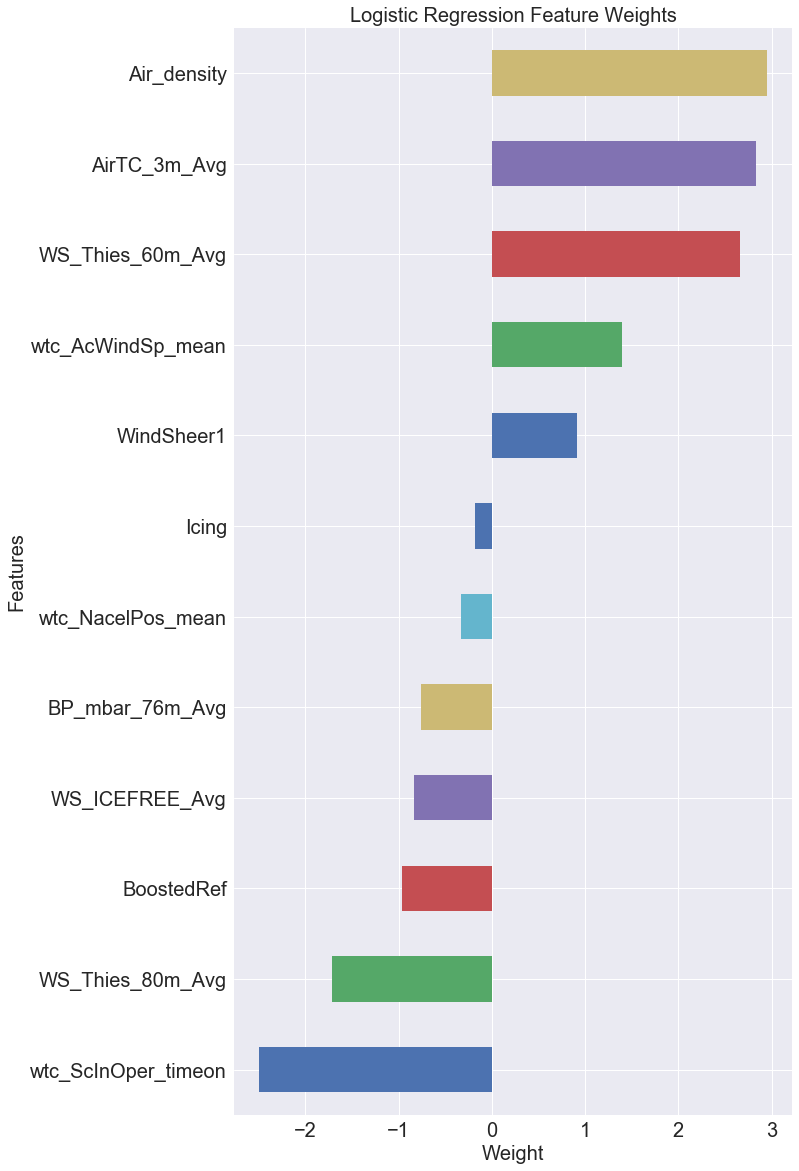

In [32]:
weights = pd.Series(lr_clf.coef_[0],index=df3.columns)
weights.sort_values(inplace=True)

plt.figure(figsize=(10, 20))
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

weights.plot(kind='barh')

plt.title("Logistic Regression Feature Weights")
plt.xlabel('Weight')
plt.ylabel('Features')
#plt.legend()
plt.show()

<a id="Model Advantages"></a>
<a href="#top">Back to Top</a>
## Model Advantages

<b>[10 points]</b>

<i>
Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.
</i>

...I"ll take some hints here.  :)  Just some bullet points and I'll elaborate.

* Logistic regression model had a better accuracy (77% vs 72%)
* Logistic regression model can only fit two classes, the SVM can be altered to support many different classes.
* SVM can take a long time to trane (especially when using cross validation). This training can be decreased by using stochasitc gradient descent. I could not fully train a SVM on my machine without SGD, let alone compare many different models.
* SVM has more options for controling model output (kernels, pentaly terms (C), gamma). This means that we can make the model more generalized or force overfitting if needed. I do not believe that this is true for logistic regression. 
* SVM can support non-linear data.
* SVM is robust to outliers.
* I think logistic regression can train faster.
* SVM is deterministic, logistic regression is probabilisitc
* Overall, SVM and Logistic regression perform comperably (when assumptions are met). SVM tends to offer a bit more flexability https://stats.stackexchange.com/questions/95340/comparing-svm-and-logistic-regression

**Question: Which model should we choose?**


### Conclusion
In the end we were able to properly classify 90% of the underperformance for this turbine(shown in the scatter plot below).

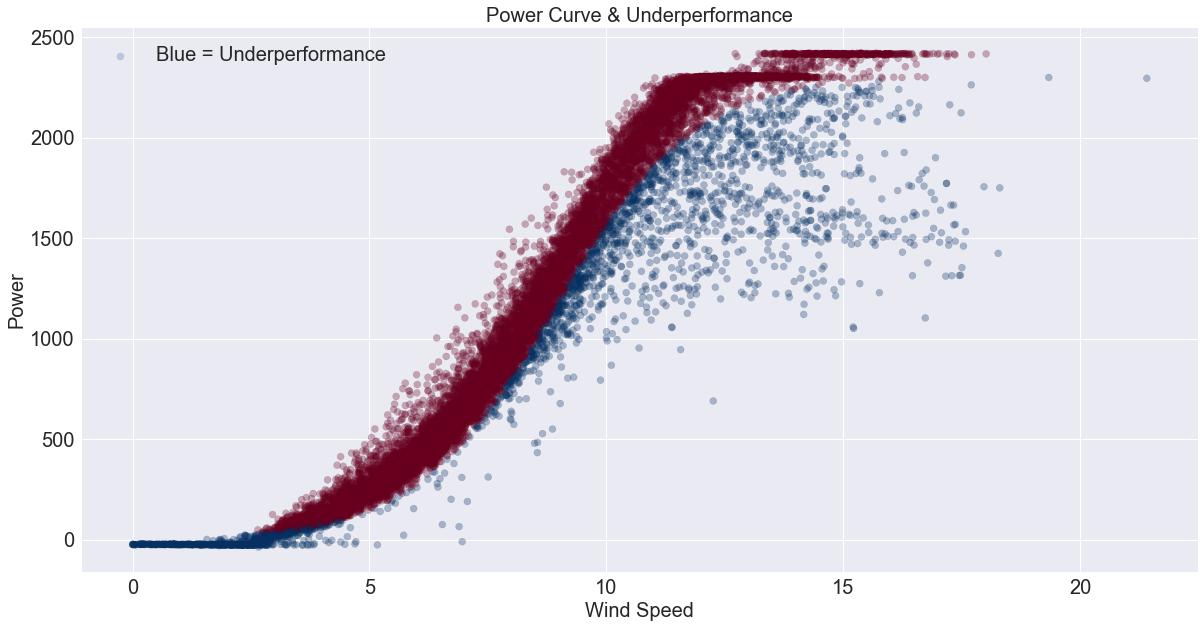

In [34]:
import matplotlib
x2 = df['wtc_AcWindSp_mean']
y2 = df['wtc_ActPower_mean'] 
c = df['Underperformance']
labels = ['Blue = Underperformance']

plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title

# plt.scatter(x1, y1,alpha=0.3, label='Median', c='r')
plt.scatter(x2, y2,alpha=0.3,c=c, cmap=pylab.cm.RdBu)
# plt.scatter(x3, y3,alpha=0.3, label='Reference', c='k')
# plt.axhline(y=2300, color='k')
plt.title("Power Curve & Underperformance")
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.legend(labels)
plt.show()